In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
import src.helmholtz as hel

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
def calc_err(result, tt_trace):
    θ = result.grid
    u_ana = tt_trace[0](θ)
    v_ana = tt_trace[1](θ)

    u_num = result.trace
    v_num = result.scaled_normal_trace

    return (
        np.abs(u_num - u_ana).max() / np.abs(u_ana).max(),
        np.abs(v_num - v_ana).max() / np.abs(v_ana).max(),
    )

In [7]:
def plot_err(param):
    ɛ_vec = param["ɛ_vec"]
    nb_ɛ = np.size(ɛ_vec, 0)

    α = param["α"]
    k = param["k"]
    type_wave = param["type_wave"]
    m = param["m"]

    N = param["N"]

    solvers = [
        hel.bie.get_total_field_pqr,
        hel.bie.get_total_field_qpax,
    ]

    err_u = np.zeros((nb_ɛ, len(solvers)))
    err_v = np.zeros((nb_ɛ, len(solvers)))

    for s, solver in enumerate(solvers):

        for i, ɛ in enumerate(ɛ_vec):
            obs = hel.create_obstacle(
                ɛ=ɛ, bdy_type=hel.BoundaryType.PENETRABLE, σ=param["σ"], ρ=param["ρ"]
            )

            if type_wave.startswith("ful"):
                in_field = hel.analytic.plane_wave_field(obs, α, k, m)
            else:
                in_field = hel.analytic.create_one_field(obs, k, type_wave, 1, m)

            sc_field = hel.analytic.get_scatter_field(obs, in_field)
            tt_trace = hel.get_total_trace(obs, in_field, sc_field)

            err_u[i, s], err_v[i, s] = calc_err(
                solver(obs, k, hel.get_incident_trace_expansion(in_field), N), tt_trace
            )

    fig_size = [1.25 * e for e in [2 * 6.4, 4.8]]
    fig, axs = plt.subplots(ncols=2, figsize=fig_size, constrained_layout=True)

    marker_vec = ("o", "X")
    for n, leg in enumerate(param["legends"]):
        axs[0].loglog(ɛ_vec, err_u[:, n], f"{marker_vec[n]}--", label=leg)
        axs[1].loglog(ɛ_vec, err_v[:, n], f"{marker_vec[n]}--", label=leg)

    if param["slope"][0]:
        ε_ = np.array([1e-8, 1e-3])
        axs[0].loglog(ε_, 10 ** (-0.5) * ε_, "k", label=r"$\mathcal{O}(\varepsilon)$")
        axs[1].loglog(ε_, 10 ** (-0.5) * ε_, "k", label=r"$\mathcal{O}(\varepsilon)$")

    if param["slope"][1]:
        ε_ = np.array([1e-7, 1e-3])
        axs[0].loglog(ε_, ε_**2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$")
        axs[1].loglog(ε_, ε_**2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$")

    for ax in axs:
        # ax.set_xlim(*param["xlim"])
        ax.set_xlabel(r"$\varepsilon$", fontsize=15)
        # ax.set_ylim(*param["ylim"])
        ax.set_ylabel("relative error", fontsize=15)
        ax.grid(True)
        ax.legend(fontsize=15)
        ax.legend(fontsize=6, loc = 'lower right')
        ax.minorticks_off()

    return None


def plot_3(ε_vec, σ, ρ, α, k, type_wave, m, N, slope):
    plot_err(
        {
            "σ": σ,
            "ρ": ρ,
            "type_wave": type_wave,
            "m": m,
            "α": α,
            "k": k,
            "ɛ_vec": ɛ_vec,
            "N": N,
            "legends": ("PQR", "QPAX"),
            "slope": slope,
            "xlim": (1e-8 / 10**0.5, 1 * 10**0.5),
            "ylim": (1e-9, 1e2),
        }
    )
    return None

In [19]:
## Ellipse parameter
σ = 1
ρ = 4
## Incident field parameters
α = 0  # (cos(α), sin(α)) direction of the plane wave
k = 2  # wavenumber direction of the plane wave
## Discretization parameters
N = 300  # Number of quadrature points

nb_ɛ = 16  # Number of ε
ɛ_min, ɛ_max = 1e-8, 0.9  # Limits for ε
ɛ_vec = np.geomspace(ɛ_min, ɛ_max, num=nb_ɛ)

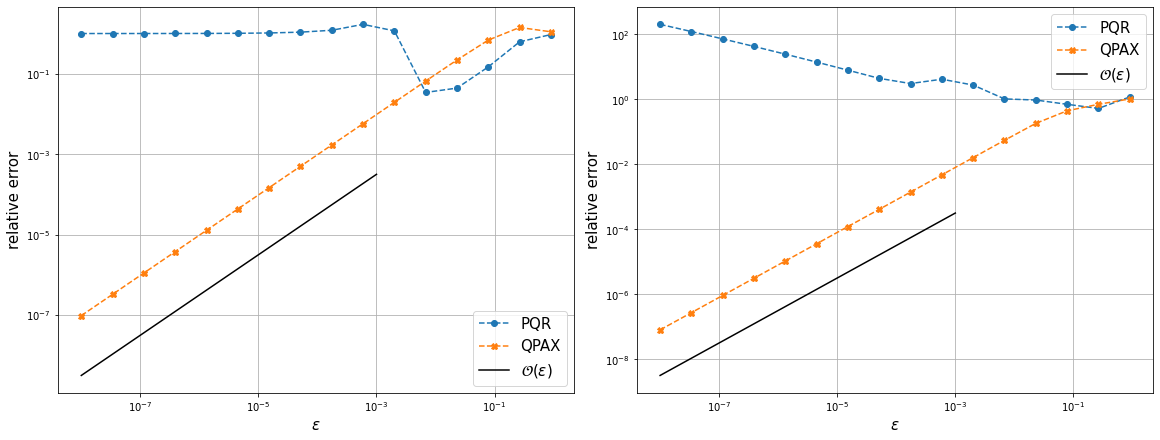

In [20]:
plot_3(ɛ_vec, σ, ρ, α, k, "full", 8, N, (True, False))